Creates dataset based on the range fft spectrogram data. Only 5-25 bins are taken (same as orignal spectrograms). 
With 64 bins and 0.1s time step dataset is expected to be around 120GB
20 bins with 0.1s time step is hopefully only around 40GB?

To handle the large size of data, this method saves each array as a seperate file and uses a key to store the labels and file name. Intended to be used later with a  Data Generator.
MTI filter applied.

In [1]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\data_processing\\wavenet':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    

DATA_PATH = BASE_PATH + 'data/'
RAW_PATH = DATA_PATH + 'raw/raw_converted/'
PROCESSED_PATH = DATA_PATH + 'processed/wavenet/range_fft_bins_5_25_mti/'
    
from src.data import load_data
from src.visualization import multiple_plots, visualize, plot_confusion_matrix
from src.features import make_spectrograms, process_labels, make_directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib import colors
from scipy.signal import butter, freqz, lfilter, spectrogram
import time
from sklearn import preprocessing

In [3]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle

Using TensorFlow backend.


In [0]:
LOWER_BIN = 5
UPPER_BIN = 25

In [0]:
labels = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
processed = {"A":{}, "B":{}, "C":{}, "D":{}, "E":{}, "F":{}}
for name, item in processed.items():
    for label in labels:
        item[label] = []

In [0]:
df_labels = pd.read_csv(RAW_PATH + 'Labels.csv')
df_labels.rename(columns={'dataset ID':'dataset_id'}, inplace=True)
df_labels = process_labels.process_labels(df_labels)

In [0]:
def nearest_odd_number(x):
    if(np.floor(x) % 2 == 0):
        return int(np.floor(x) + 1)
    else:
        return int(np.floor(x))

In [0]:
def create_range_fft(reshaped_data):
    win = np.ones(reshaped_data.shape)
    # Apply fast fourier transform should compute distance (range) from objects
    fft_applied = np.fft.fft((reshaped_data * win), axis=0)
    return fft_applied[LOWER_BIN:UPPER_BIN, :] # take half for some reason?

In [0]:
def MTI_filter(range_fft):
    # IIR Notch filter
    x = range_fft.shape[1]
    ns = nearest_odd_number(x) - 1
    data_range_MTI = np.zeros((range_fft.shape[0], ns), dtype=np.complex128)
    (b, a) = butter(4, 0.01, btype="high")
    # Apply Filter
    for i in range(range_fft.shape[0]):
        data_range_MTI[i, :ns] = lfilter(b, a, range_fft[i, :ns], axis=0)
    # Remove first range bin as has strong residual possibly from filtering?
    return data_range_MTI[1:, :]

In [0]:
WINDOW_LENGTH = 3 # 3 seconds windows
STEP_SIZE = 1000 # 1 second steps
STEP_SIZE = 100 # 0.1 second steps

In [0]:
SAVE_FILE = False
DATA_SHAPE_0 = 60000 

F 0 walking


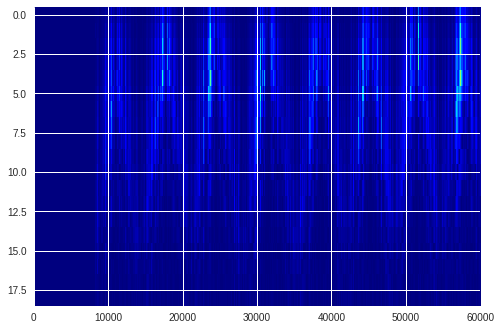

F 0 walking


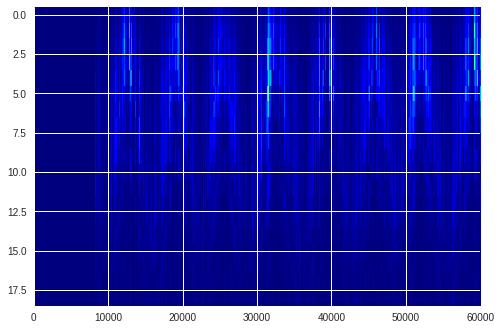

In [14]:
number_of_rows = df_labels.shape[0]
current_row = 1
for row in df_labels.itertuples():
    if row.user_label != "F" or row.aspect_angle != "0" or row.label != "walking":
        continue
    print(row.user_label, row.aspect_angle, row.label)
        
    file_name = RAW_PATH + "Dataset_" + str(row.dataset_id) + ".dat"
    radar_df = pd.read_csv(file_name, header=None)[1]

    # Grab RADAR settings from top of file
    center_frequency = float(radar_df.iloc[1])
    sweep_time = float(radar_df.iloc[2])/1000  # convert to seconds
    number_of_time_samples = float(radar_df.iloc[3])
    bandwidth = float(radar_df.iloc[4])
    sampling_frequency = number_of_time_samples/sweep_time
    record_length = 60
    number_of_chirps = record_length/sweep_time

    # Put data values into an array
    data = radar_df.iloc[5:].apply(complex).values

    # Reshape into chirps over time
    data_time = np.reshape(data, (int(number_of_chirps),int(number_of_time_samples)))    
    data_time = np.rot90(data_time, k=-1) # make axis 0 be chirp and axis 1 be time (makes visualization clearer)

    # compute range fft
    range_fft = create_range_fft(data_time)

    # Apply MTI filter to remove stationary objects
    data_time = MTI_filter(range_fft)
    plt.imshow(abs(data_time),cmap='jet', aspect="auto")
    plt.show()
    continue
    data_time = np.rot90(data_time) # undo earlier rotation to make time axis 0 and bin axis 1

    window_size = int(WINDOW_LENGTH * 1000)
    iterations = data_time.shape[0] - window_size

        
    sub_label = 0
    file_names = []
    for i in range(0, iterations, STEP_SIZE):
        data_file_name = str(current_row) + "_" + str(sub_label) + ".npy"
#         np.save(PROCESSED_PATH + data_file_name, data_time[i:(i + window_size),:])   
        file_names.append(data_file_name)
        sub_label += 1
        
    processed[row.user_label][row.label].append(file_names)

    current_row += 1

    
# with open(PROCESSED_PATH + "index.pkl", "wb") as file:
#     pickle.dump(processed, file)